%%capture
import sklearn # import before to get new version
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

import logging
log = logging.getLogger()
log.setLevel("DEBUG")

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled)


In [3]:
train, val, test = pickle.load(gzip.open('data/mnist/mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

## Two digit

In [4]:
X_train_topo = X_train.reshape(X_train.shape[0], 28,28)
X_val_topo = X_val.reshape(X_val.shape[0], 28,28)

from numpy.random import RandomState

rng = RandomState(98787)
random_inds = range(len(X_train))
rng.shuffle(random_inds)

X_train_topo_both = np.concatenate([X_train_topo, X_train_topo[random_inds]], axis=2)
X_train_flat_both = X_train_topo_both.reshape(X_train_topo_both.shape[0],-1)
y_train_both = np.logical_or(y_train < 3, y_train[random_inds] < 3).astype(np.int32)
rng = RandomState(987837)
random_val_inds = range(len(X_val))
rng.shuffle(random_val_inds)
X_val_topo_both = np.concatenate([X_val_topo, X_val_topo[random_val_inds]], axis=2)
X_val_flat_both = X_val_topo_both.reshape(X_val_topo_both.shape[0],-1)
y_val_both = np.logical_or(y_val < 3, y_val[random_val_inds] < 3).astype(np.int32)

In [5]:
from braindecode.veganlasagne.layers import print_layers
three_layer_model = np.load('data/mnist/two-digit/three-conv-pool-negative-bias.pkl')

all_layers = lasagne.layers.get_all_layers(three_layer_model)
print_layers(three_layer_model)



 0 InputLayer                (None, 1568)
 1 ReshapeLayer              (None, 1, 28, 56)
 2 Conv2DLayer               (None, 3, 26, 54)
 3 Pool2DLayer               (None, 3, 13, 27)
 4 Conv2DLayer               (None, 3, 12, 26)
 5 Pool2DLayer               (None, 3, 6, 13)
 6 Conv2DLayer               (None, 3, 4, 12)
 7 Pool2DLayer               (None, 3, 2, 6)
 8 DenseLayer                (None, 2)


In [6]:
from braindecode.veganlasagne.layers import split_out_nonlinearities, split_out_biases
three_layer_model = split_out_nonlinearities(three_layer_model)
three_layer_model = split_out_biases(three_layer_model)
all_layers = lasagne.layers.get_all_layers(three_layer_model)
print_layers(all_layers)

 0 InputLayer                (None, 1568)
 1 ReshapeLayer              (None, 1, 28, 56)
 2 Conv2DLayer               (None, 3, 26, 54)
 3 BiasLayer                 (None, 3, 26, 54)
 4 NonlinearityLayer         (None, 3, 26, 54)
 5 Pool2DLayer               (None, 3, 13, 27)
 6 Conv2DLayer               (None, 3, 12, 26)
 7 BiasLayer                 (None, 3, 12, 26)
 8 NonlinearityLayer         (None, 3, 12, 26)
 9 Pool2DLayer               (None, 3, 6, 13)
10 Conv2DLayer               (None, 3, 4, 12)
11 BiasLayer                 (None, 3, 4, 12)
12 NonlinearityLayer         (None, 3, 4, 12)
13 Pool2DLayer               (None, 3, 2, 6)
14 DenseLayer                (None, 2)
15 NonlinearityLayer         (None, 2)


## Compute all activations

In [7]:
inputs = T.fmatrix()
outputs = lasagne.layers.get_output(all_layers, inputs=inputs)
all_out_fn = theano.function([inputs], outputs)
all_outs_per_layer = all_out_fn(X_train_flat_both)

In [8]:
acc = (sum(np.argmax(all_outs_per_layer[-1], axis=1) == y_train_both) 
    / float(len(y_train_both)))
print("Accuracy {:.2f}".format(acc * 100))

Accuracy 92.63


## Compute all patterns

In [10]:
from braindecode.analysis.patterns import (compute_topo_covariances, transform_to_patterns,
                                           compute_patterns_for_layers, compute_patterns_for_model,
                                          pattern_deconv)

In [11]:
patterns_per_layer = compute_patterns_for_model(three_layer_model, X_train_flat_both)

INFO:braindecode.analysis.patterns:Compiling forward pass...
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 0: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 1: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 2: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 3: DenseLayer...


## Test reconstruction from different levels

In [12]:
from braindecode.analysis.patterns import pattern_deconv

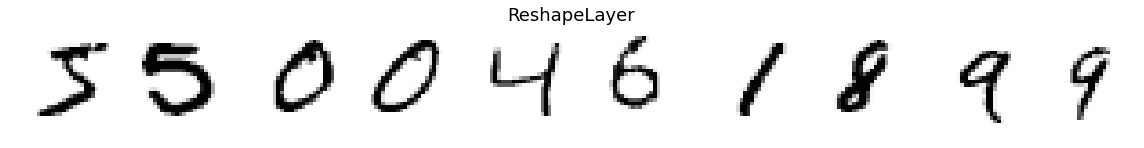

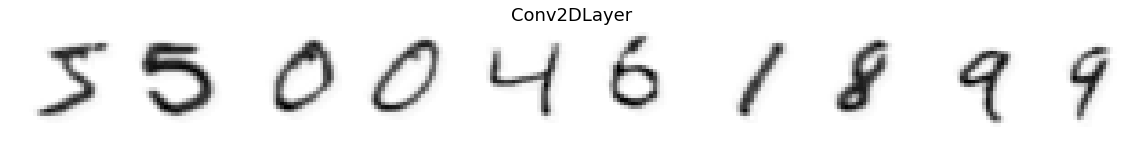

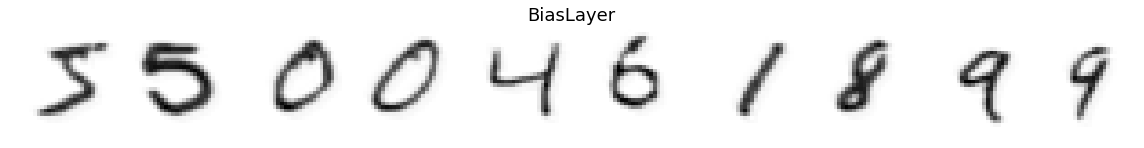

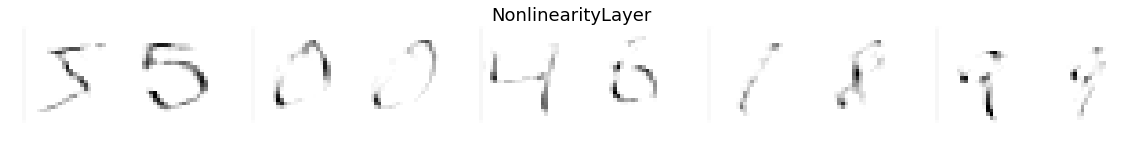

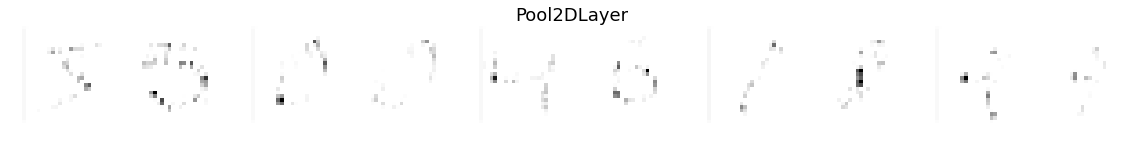

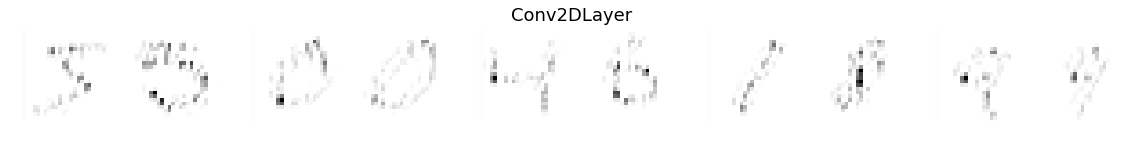

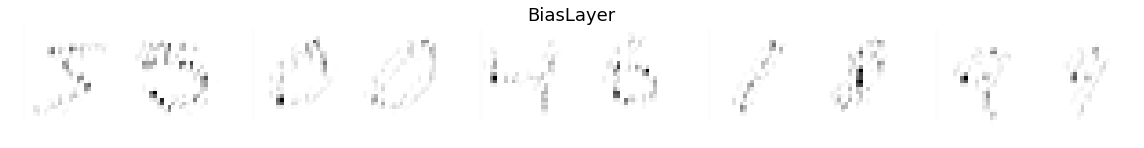

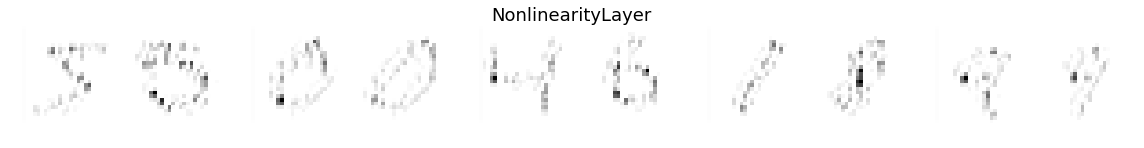

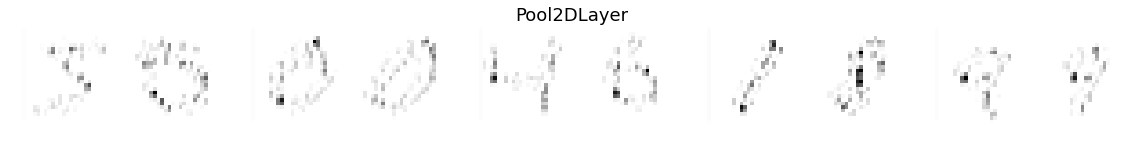

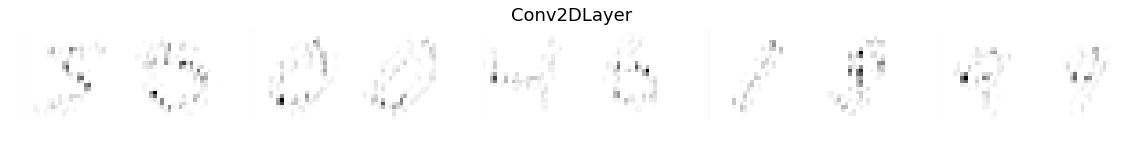

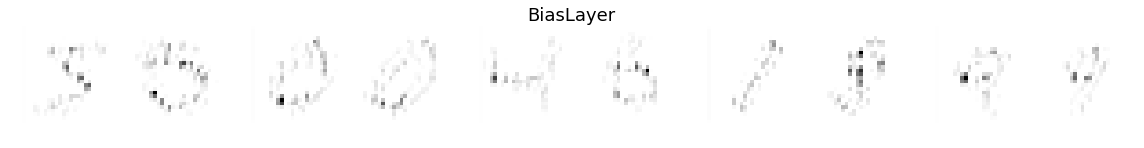

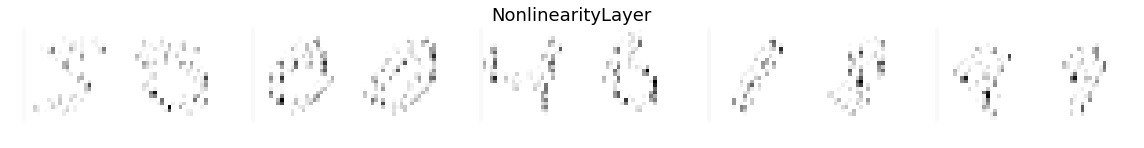

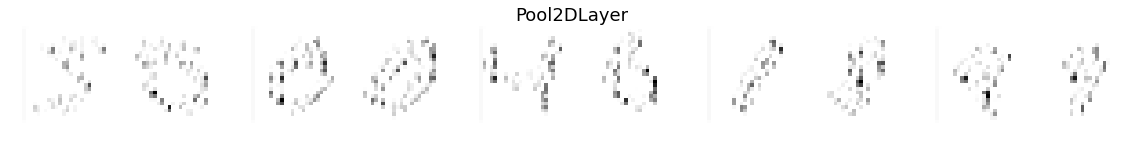

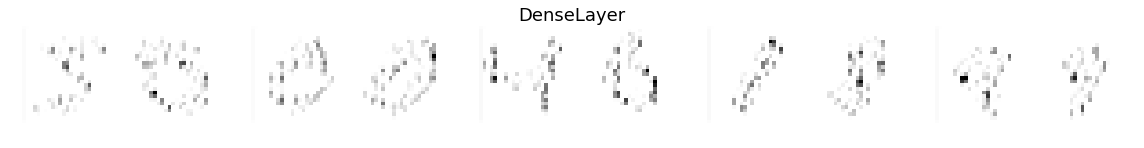

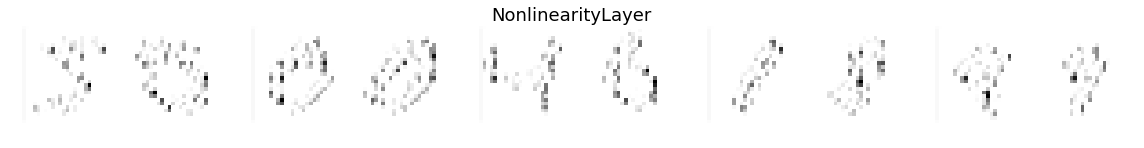

In [13]:
from matplotlib import cm
trial_inds = range(5)
for i_layer in xrange(1,len(all_layers)):
    inputs = T.fmatrix()
    if len(all_layers[i_layer].output_shape) > 2:
        outputs = T.ftensor4()
    else:
        outputs = T.fmatrix()
    this_layers = all_layers[1:i_layer+1]
    n_patterns = len([l for l in this_layers if hasattr(l, 'W')])
    deconved_var = pattern_deconv(outputs, inputs, this_layers, patterns_per_layer[:n_patterns],
                                  patterns_flipped=False,
                             enforce_positivity_everywhere=False)
    if i_layer > 1:
        pattern_deconv_fn = theano.function([outputs, inputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds], 
                                     X_train_flat_both[trial_inds])
    else:
        pattern_deconv_fn = theano.function([outputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds])
    
    # lets try make  deconved positive at end
    deconved = deconved * (deconved > 0)
    fig = plt.figure(figsize=(16,2))
    for i_example in xrange(len(deconved)):
        plt.subplot(1, len(deconved), i_example+1)
        plt.imshow(deconved[i_example].squeeze(), interpolation='nearest', cmap=cm.Greys)
        plt.axis('off')
    fig.suptitle(all_layers[i_layer].__class__.__name__, fontsize=18)
    plt.axis('off')
    plt.tight_layout()

## Older verisons (first one should be identical) - to delete

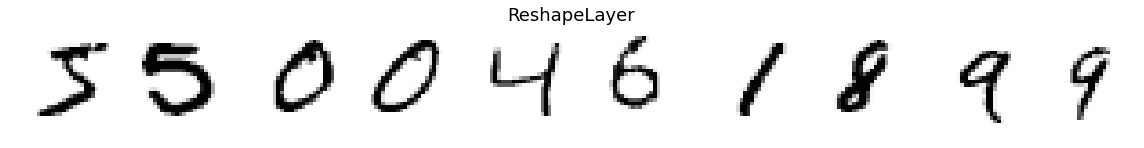

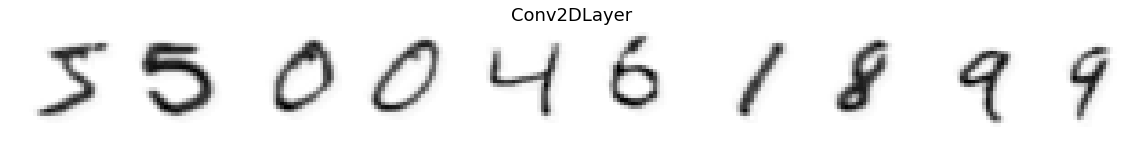

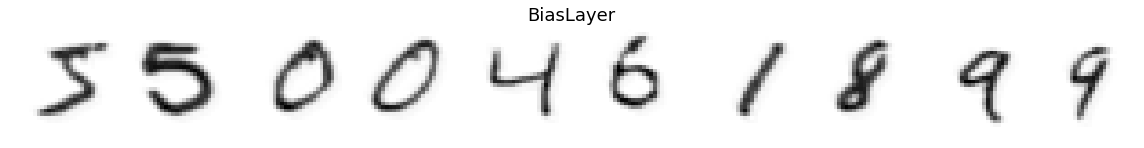

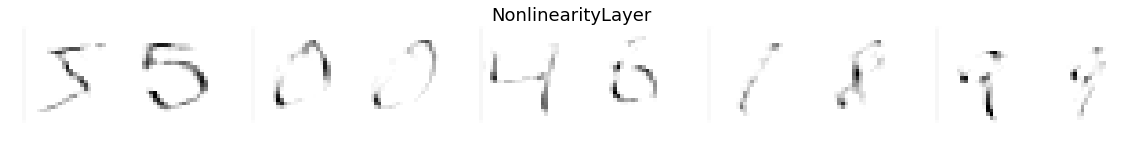

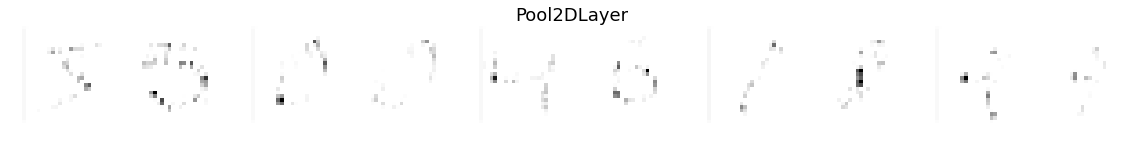

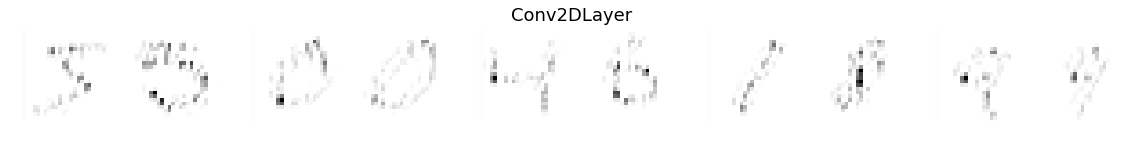

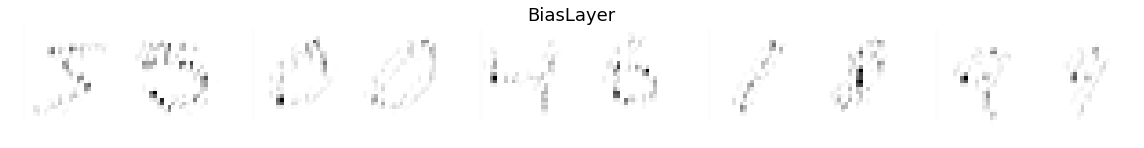

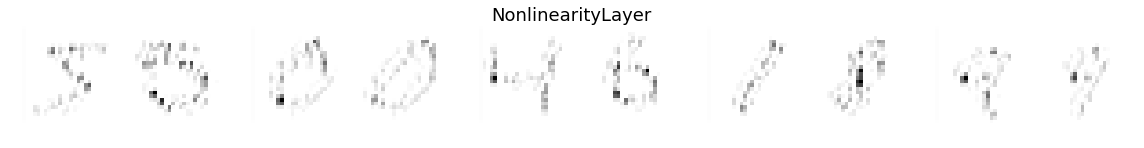

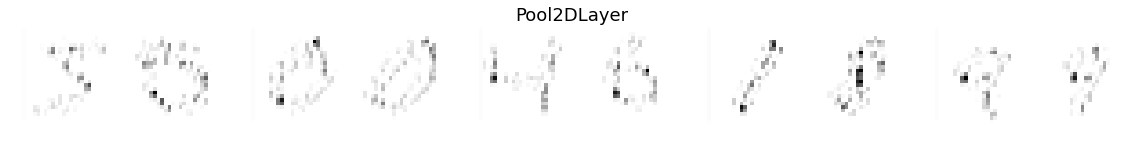

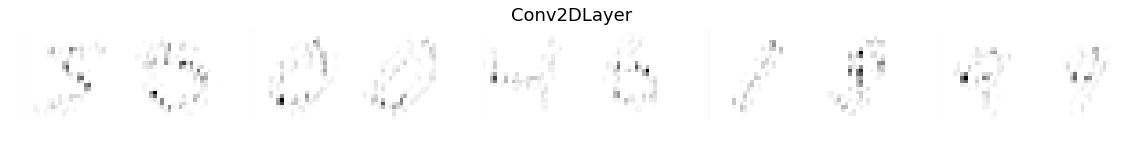

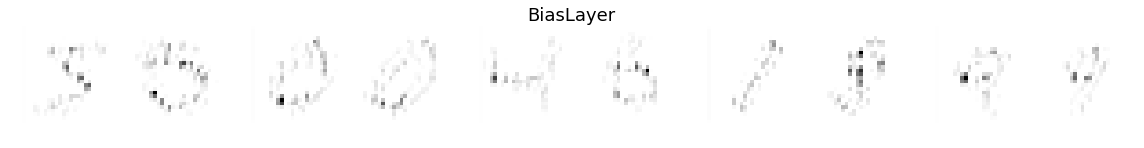

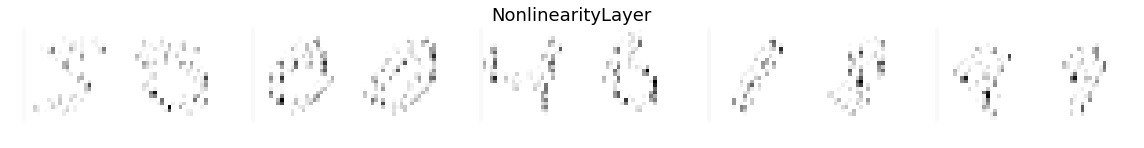

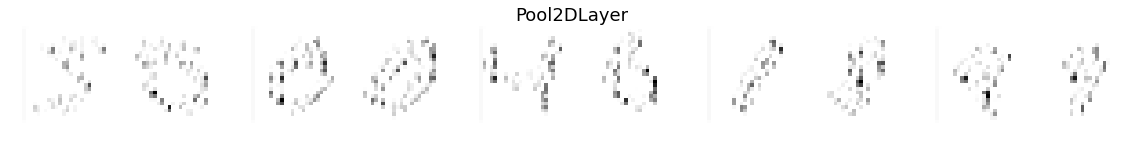

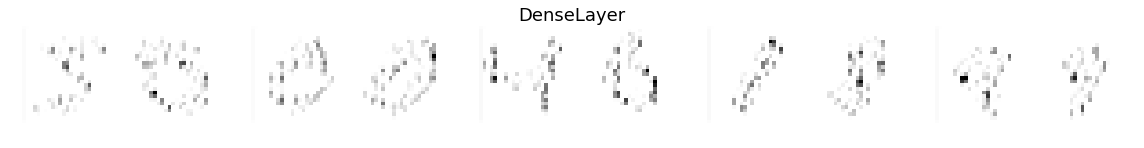

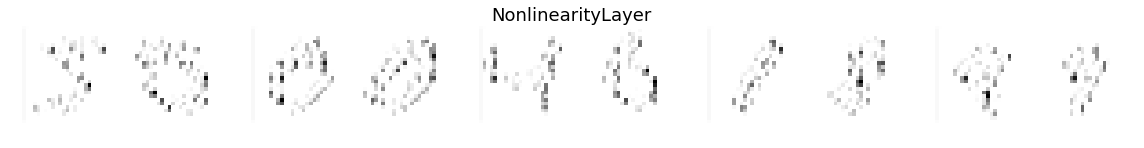

In [20]:
from matplotlib import cm
trial_inds = range(5)
for i_layer in xrange(1,len(all_layers)):
    inputs = T.fmatrix()
    if len(all_layers[i_layer].output_shape) > 2:
        outputs = T.ftensor4()
    else:
        outputs = T.fmatrix()
    this_layers = all_layers[1:i_layer+1]
    n_patterns = len([l for l in this_layers if hasattr(l, 'W')])
    deconved_var = pattern_deconv(outputs, inputs, this_layers, patterns_per_layer[:n_patterns],
                                  patterns_flipped=False,
                             enforce_positivity_everywhere=False)
    if i_layer > 1:
        pattern_deconv_fn = theano.function([outputs, inputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds], 
                                     X_train_flat_both[trial_inds])
    else:
        pattern_deconv_fn = theano.function([outputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds])
    
    # lets try make  deconved positive at end
    deconved = deconved * (deconved > 0)
    fig = plt.figure(figsize=(16,2))
    for i_example in xrange(len(deconved)):
        plt.subplot(1, len(deconved), i_example+1)
        plt.imshow(deconved[i_example].squeeze(), interpolation='nearest', cmap=cm.Greys)
        plt.axis('off')
    fig.suptitle(all_layers[i_layer].__class__.__name__, fontsize=18)
    plt.axis('off')
    plt.tight_layout()

In [33]:
weights_per_layer = lasagne.layers.get_all_param_values(this_layers)[::3]
# since patterns are flipped, lets flip the conv weights
weights_per_layer[:3] = [w[:,:,::-1,::-1] for w in weights_per_layer[:3]] 

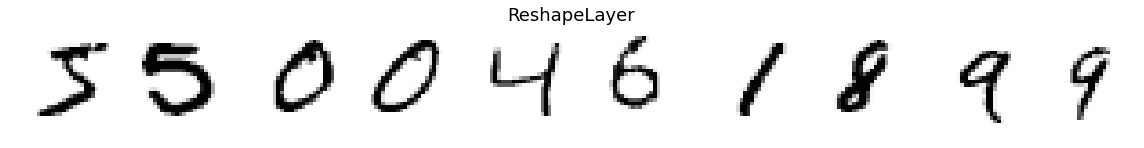

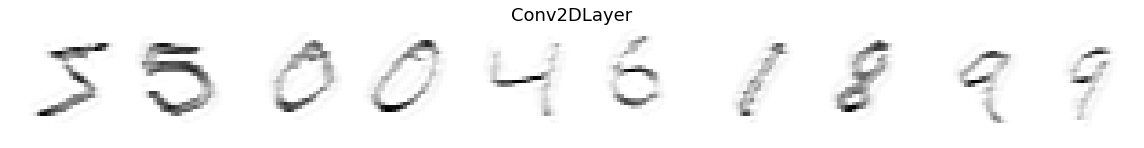

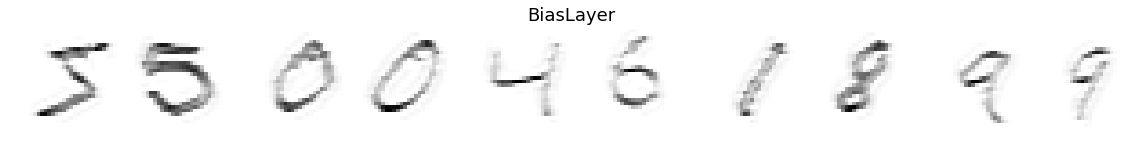

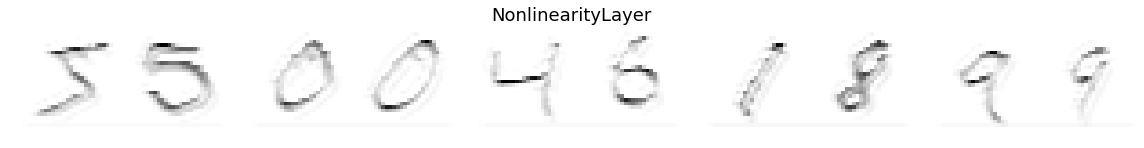

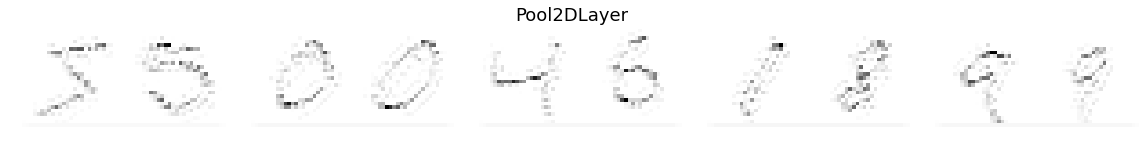

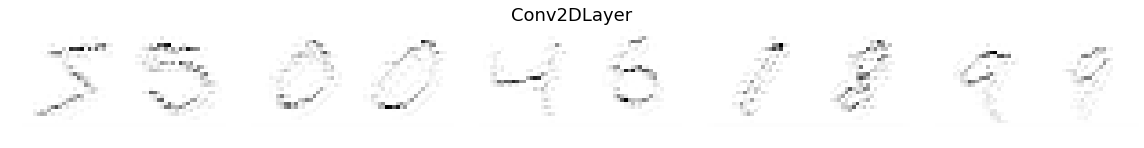

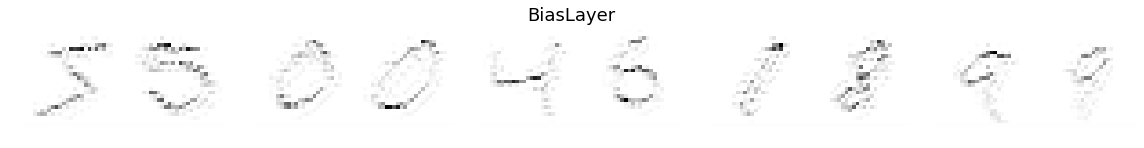

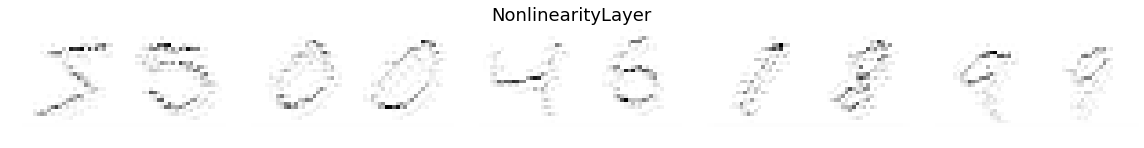

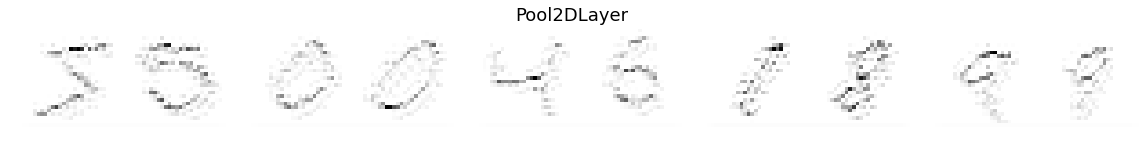

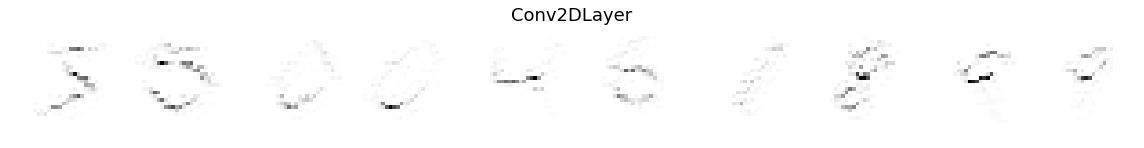

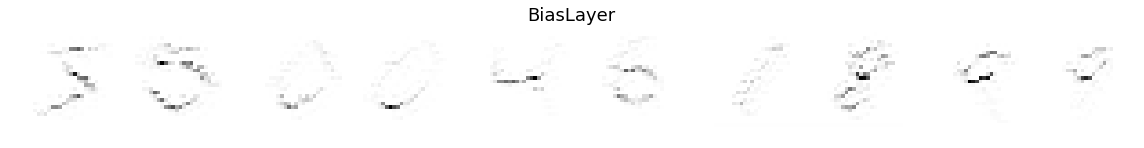

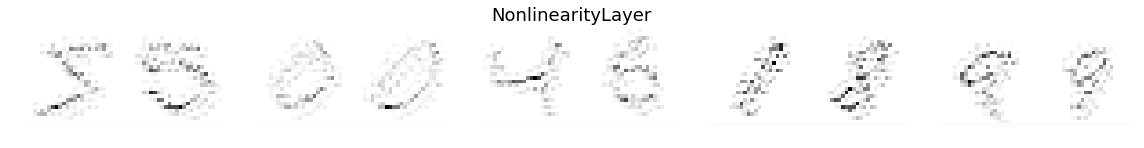

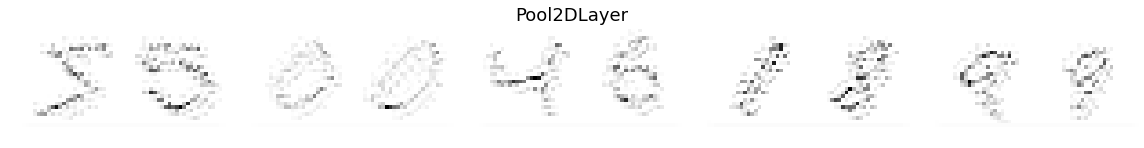

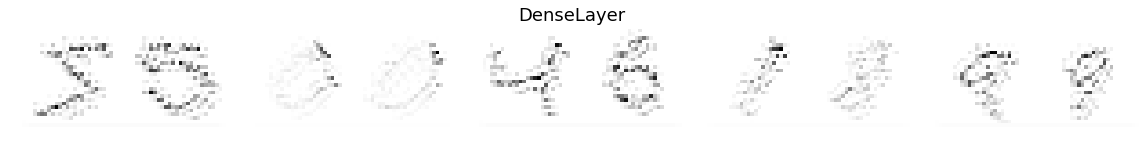

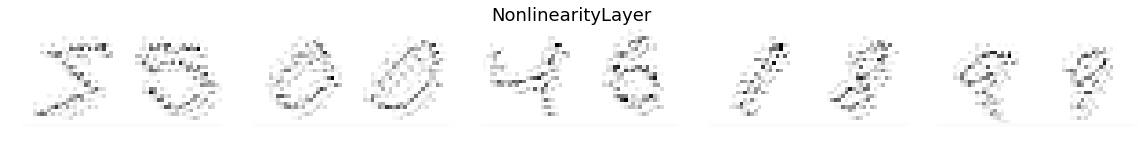

In [34]:
from matplotlib import cm
trial_inds = range(5)
for i_layer in xrange(1,len(all_layers)):
    inputs = T.fmatrix()
    if len(all_layers[i_layer].output_shape) > 2:
        outputs = T.ftensor4()
    else:
        outputs = T.fmatrix()
    this_layers = all_layers[1:i_layer+1]
    n_patterns = len([l for l in this_layers if hasattr(l, 'W')])
    deconved_var = pattern_deconv(outputs, inputs, this_layers, weights_per_layer[:n_patterns],
                                  patterns_flipped=False,
                             enforce_positivity_everywhere=False)
    if i_layer > 1:
        pattern_deconv_fn = theano.function([outputs, inputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds], 
                                     X_train_flat_both[trial_inds])
    else:
        pattern_deconv_fn = theano.function([outputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds])
    
    # lets try make  deconved positive at end
    deconved = deconved * (deconved > 0)
    fig = plt.figure(figsize=(16,2))
    for i_example in xrange(len(deconved)):
        plt.subplot(1, len(deconved), i_example+1)
        plt.imshow(deconved[i_example].squeeze(), interpolation='nearest', cmap=cm.Greys)
        plt.axis('off')
    fig.suptitle(all_layers[i_layer].__class__.__name__, fontsize=18)
    plt.axis('off')
    plt.tight_layout()

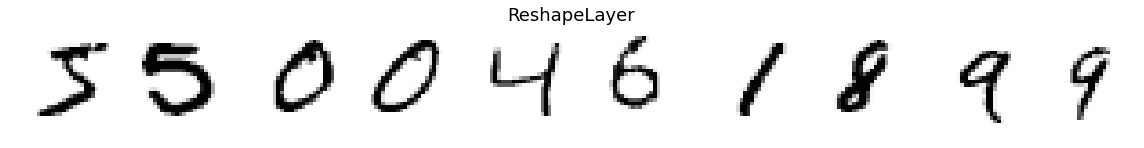

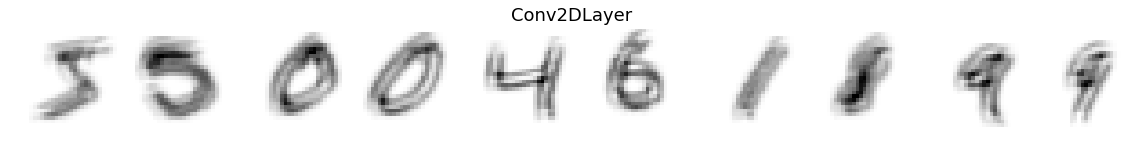

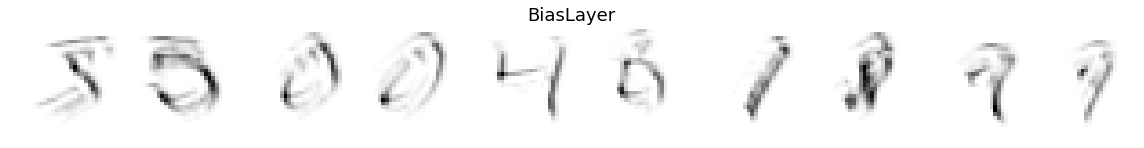

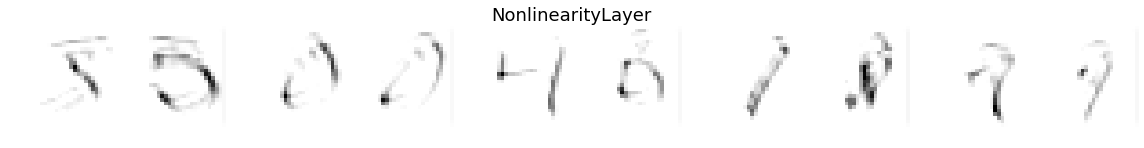

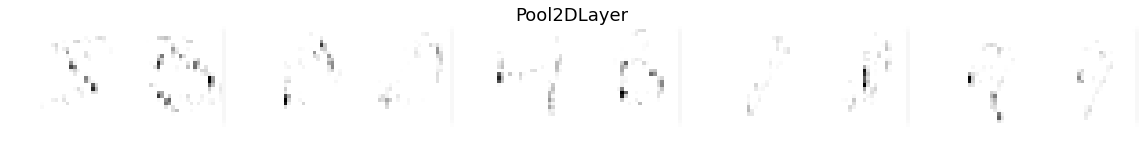

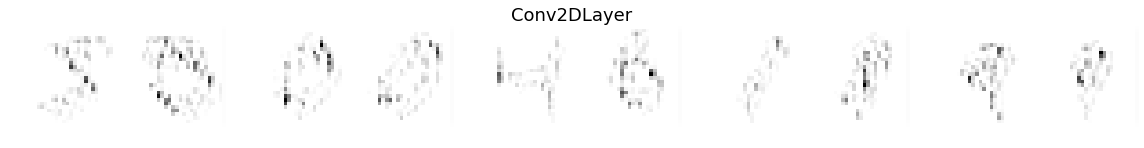

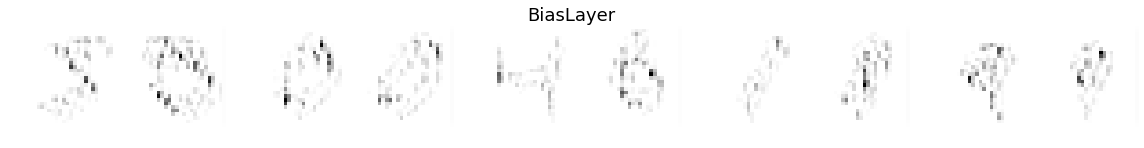

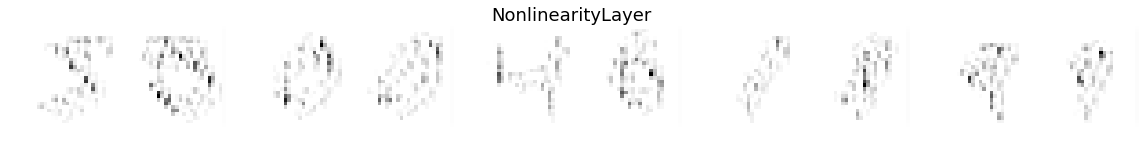

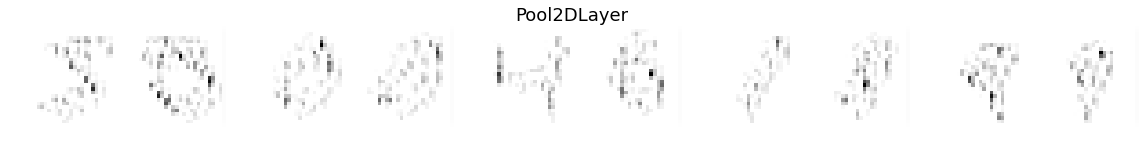

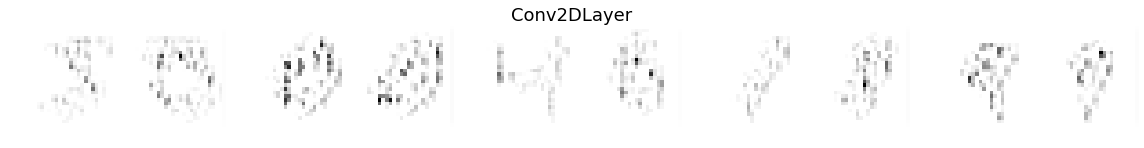

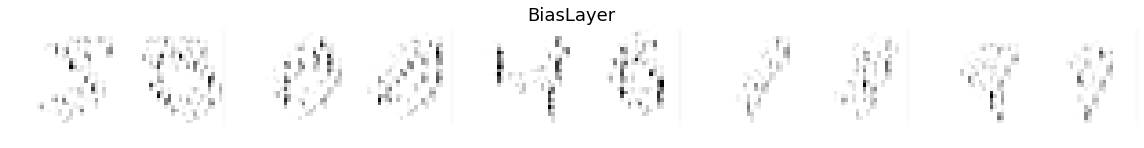

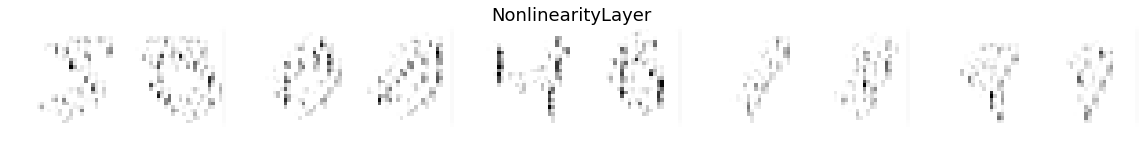

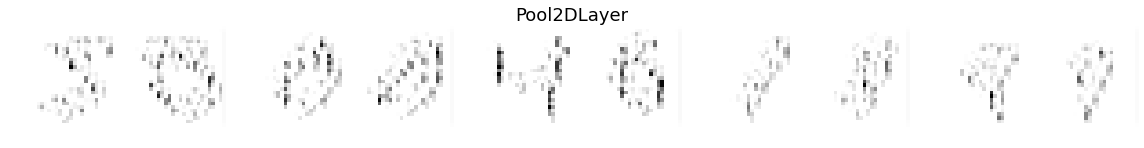

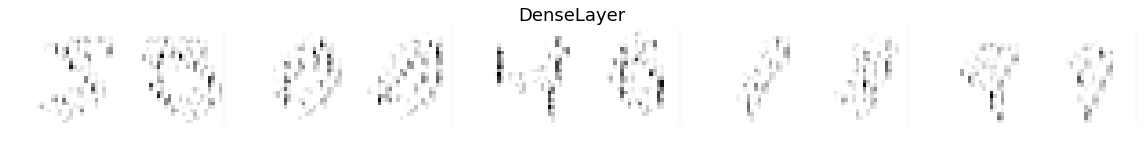

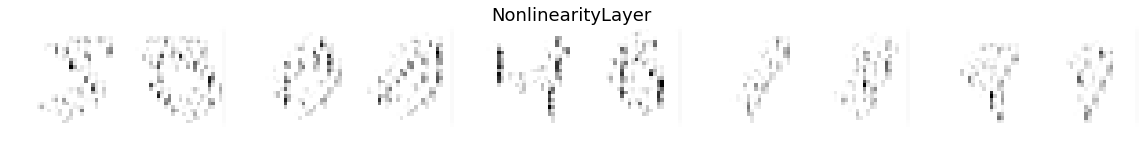

In [18]:
from matplotlib import cm
trial_inds = range(5)
for i_layer in xrange(1,len(all_layers)):
    inputs = T.fmatrix()
    if len(all_layers[i_layer].output_shape) > 2:
        outputs = T.ftensor4()
    else:
        outputs = T.fmatrix()
    this_layers = all_layers[1:i_layer+1]
    n_patterns = len([l for l in this_layers if hasattr(l, 'W')])
    deconved_var = pattern_deconv(outputs, inputs, this_layers, patterns_per_layer[:n_patterns],
                             enforce_positivity_everywhere=True)
    if i_layer > 1:
        pattern_deconv_fn = theano.function([outputs, inputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds], 
                                     X_train_flat_both[trial_inds])
    else:
        pattern_deconv_fn = theano.function([outputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds])
    fig = plt.figure(figsize=(16,2))
    for i_example in xrange(len(deconved)):
        plt.subplot(1, len(deconved), i_example+1)
        plt.imshow(deconved[i_example].squeeze(), interpolation='nearest', cmap=cm.Greys)
        plt.axis('off')
    fig.suptitle(all_layers[i_layer].__class__.__name__, fontsize=18)
    plt.axis('off')
    plt.tight_layout()

## Elu Model

In [5]:
from braindecode.veganlasagne.layers import print_layers
three_layer_model = np.load('data/mnist/two-digit/three-conv-pool-elu-positive-bias.pkl')

all_layers = lasagne.layers.get_all_layers(three_layer_model)
print_layers(three_layer_model)


 0 InputLayer                (None, 1568)
 1 ReshapeLayer              (None, 1, 28, 56)
 2 Conv2DLayer               (None, 3, 26, 54)
 3 Pool2DLayer               (None, 3, 13, 27)
 4 Conv2DLayer               (None, 3, 12, 26)
 5 Pool2DLayer               (None, 3, 6, 13)
 6 Conv2DLayer               (None, 3, 4, 12)
 7 Pool2DLayer               (None, 3, 2, 6)
 8 DenseLayer                (None, 2)


In [6]:
from braindecode.veganlasagne.layers import split_out_nonlinearities, split_out_biases
three_layer_model = split_out_nonlinearities(three_layer_model)
three_layer_model = split_out_biases(three_layer_model)
all_layers = lasagne.layers.get_all_layers(three_layer_model)
print_layers(all_layers)

 0 InputLayer                (None, 1568)
 1 ReshapeLayer              (None, 1, 28, 56)
 2 Conv2DLayer               (None, 3, 26, 54)
 3 BiasLayer                 (None, 3, 26, 54)
 4 NonlinearityLayer         (None, 3, 26, 54)
 5 Pool2DLayer               (None, 3, 13, 27)
 6 Conv2DLayer               (None, 3, 12, 26)
 7 BiasLayer                 (None, 3, 12, 26)
 8 NonlinearityLayer         (None, 3, 12, 26)
 9 Pool2DLayer               (None, 3, 6, 13)
10 Conv2DLayer               (None, 3, 4, 12)
11 BiasLayer                 (None, 3, 4, 12)
12 NonlinearityLayer         (None, 3, 4, 12)
13 Pool2DLayer               (None, 3, 2, 6)
14 DenseLayer                (None, 2)
15 NonlinearityLayer         (None, 2)


In [7]:
inputs = T.fmatrix()
outputs = lasagne.layers.get_output(all_layers, inputs=inputs)
all_out_fn = theano.function([inputs], outputs)
all_outs_per_layer = all_out_fn(X_train_flat_both)
acc = (sum(np.argmax(all_outs_per_layer[-1], axis=1) == y_train_both) 
    / float(len(y_train_both)))
print("Accuracy {:.2f}".format(acc * 100))

Accuracy 93.03


In [8]:
from braindecode.analysis.patterns import (compute_topo_covariances, transform_to_patterns,
                                           compute_patterns_for_layers, compute_patterns_for_model,
                                          pattern_deconv)
patterns_per_layer = compute_patterns_for_model(three_layer_model, X_train_flat_both)

INFO:braindecode.analysis.patterns:Compiling forward pass...
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 0: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 1: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 2: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 3: DenseLayer...


In [10]:
print [np.max(p) for p in patterns_per_layer]
print [np.mean(np.abs(p)) for p in patterns_per_layer]

[0.83204924599197949, 0.81952903895009033, 0.1876186647919974, 3.7515348884909865]
[0.22469634977524, 0.22186386114012061, 0.099331223786234032, 0.64566866823453839]


In [93]:
from braindecode.analysis.patterns import pattern_deconv
from matplotlib import cm
trial_inds = range(5)
deconved_per_layer = []
for i_layer in xrange(1,len(all_layers)):
    inputs = T.fmatrix()
    if len(all_layers[i_layer].output_shape) > 2:
        outputs = T.ftensor4()
    else:
        outputs = T.fmatrix()
    this_layers = all_layers[1:i_layer+1]
    n_patterns = len([l for l in this_layers if hasattr(l, 'W')])
    deconved_var = pattern_deconv(outputs, inputs, this_layers, patterns_per_layer[:n_patterns])
    if i_layer > 1:
        pattern_deconv_fn = theano.function([outputs, inputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds], 
                                     X_train_flat_both[trial_inds])
    else:
        pattern_deconv_fn = theano.function([outputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds])
    deconved_per_layer.append(deconved)

## With distributing equally in pool

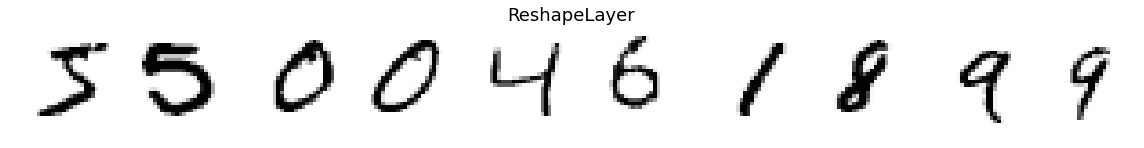

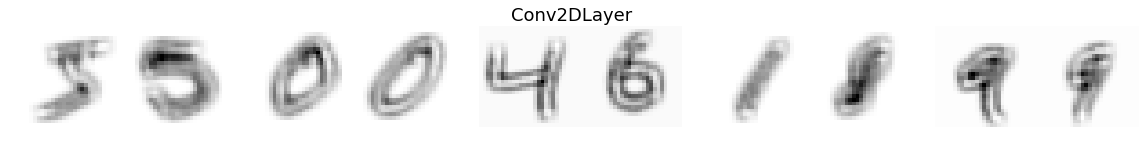

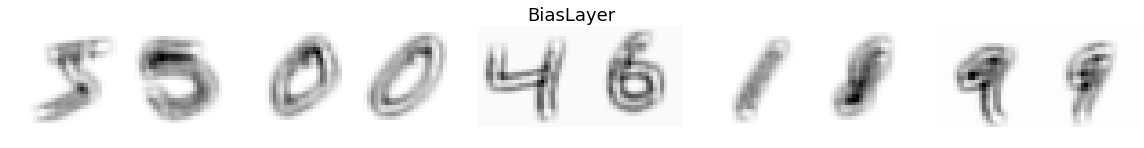

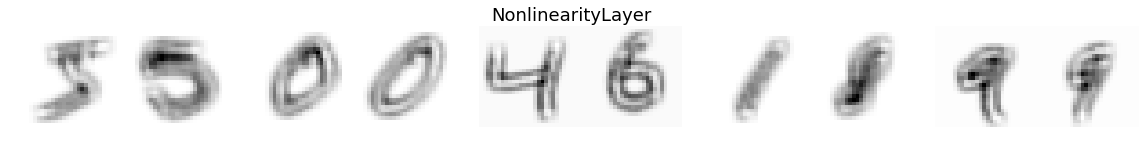

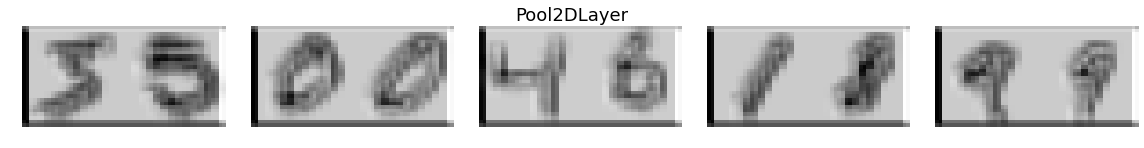

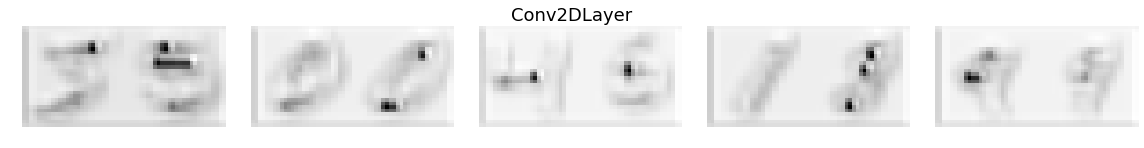

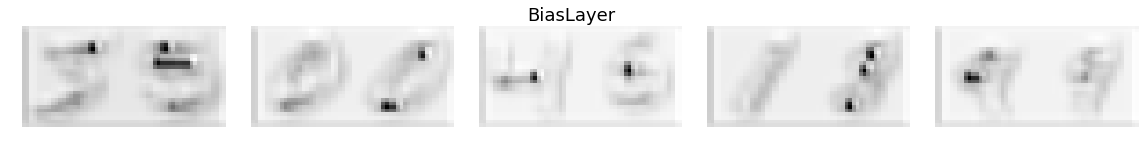

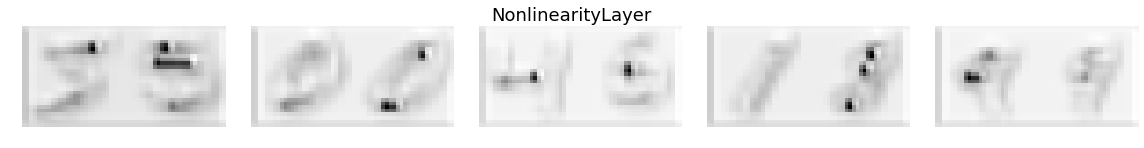

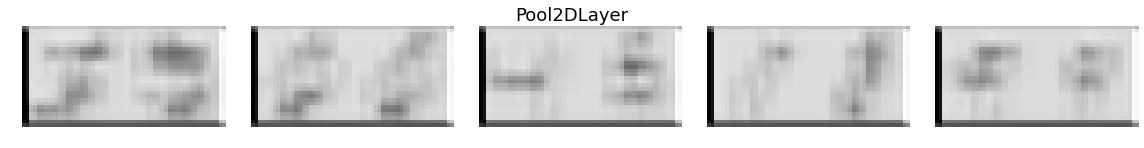

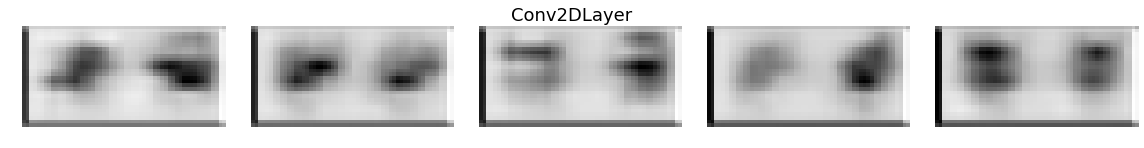

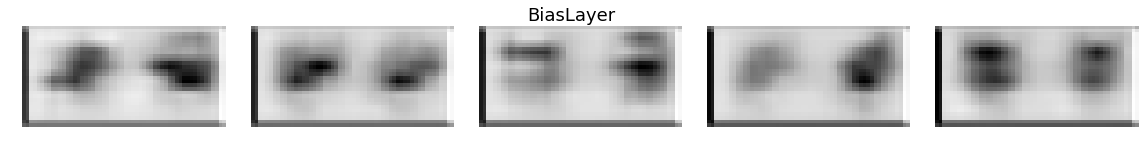

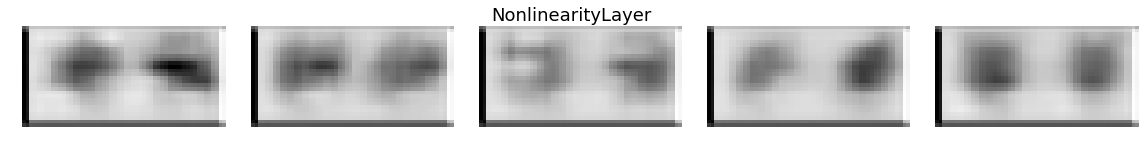

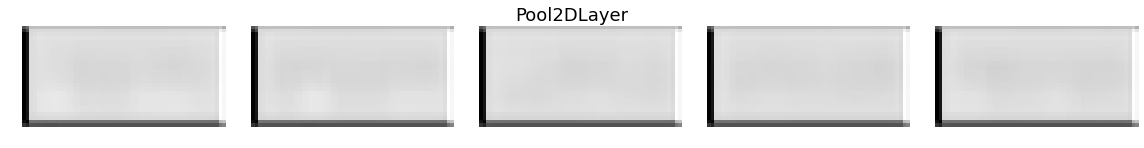

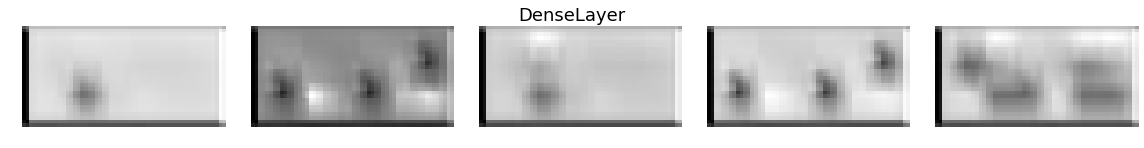

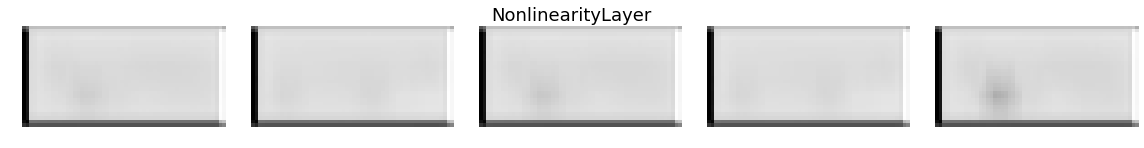

In [94]:
for i_layer, deconved in enumerate(deconved_per_layer):
    fig = plt.figure(figsize=(16,2))
    for i_example in xrange(len(deconved)):
        plt.subplot(1, len(deconved), i_example+1)
        plt.imshow(deconved[i_example].squeeze(), interpolation='nearest', cmap=cm.Greys)
        plt.axis('off')
    # i_layer + 1 since first layer not deconved
    fig.suptitle(all_layers[i_layer+1].__class__.__name__, fontsize=18)
    plt.axis('off')
    plt.tight_layout()

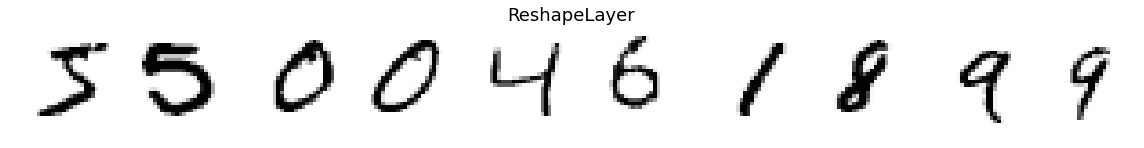

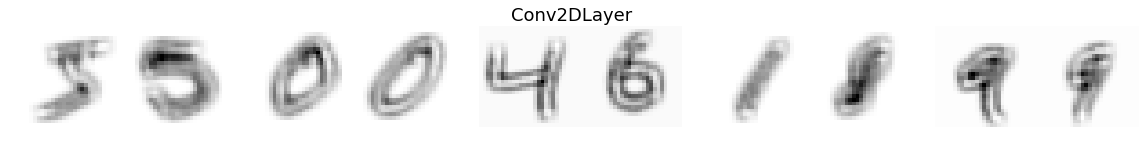

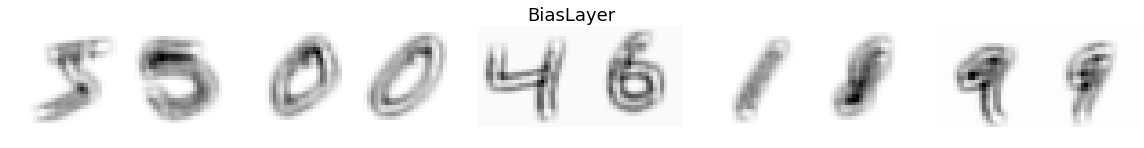

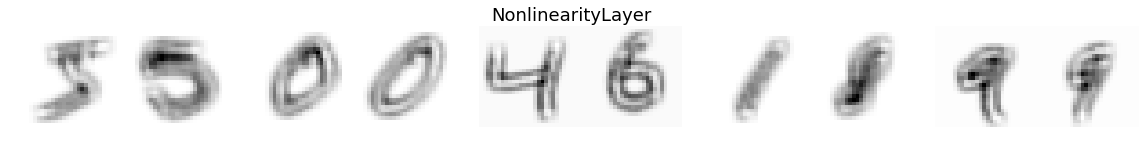

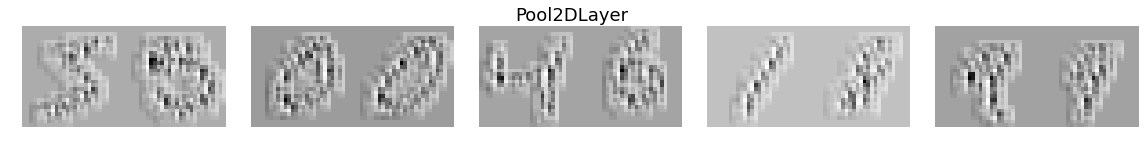

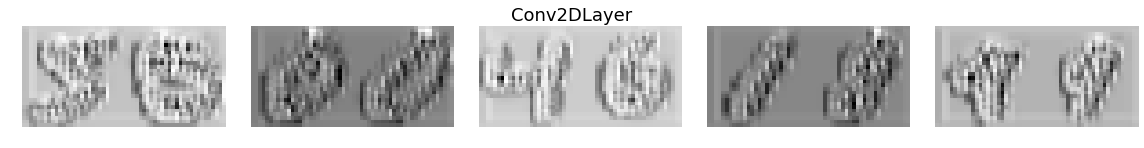

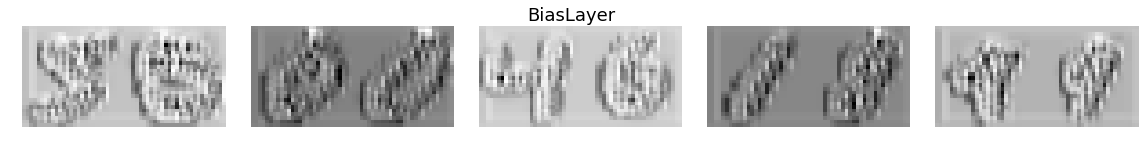

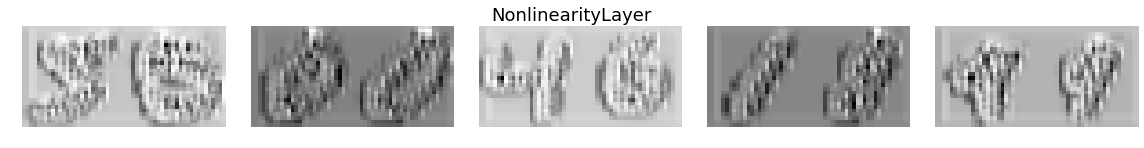

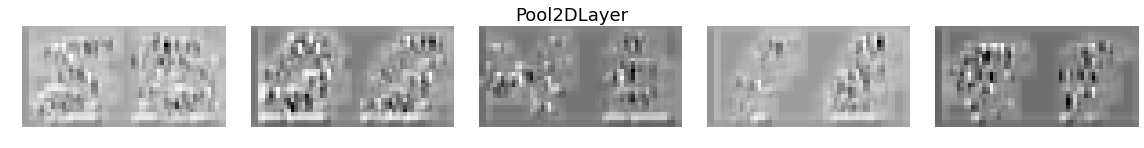

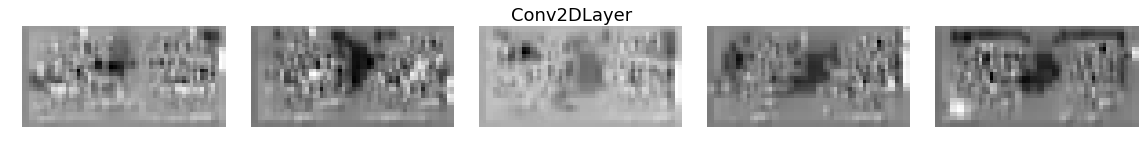

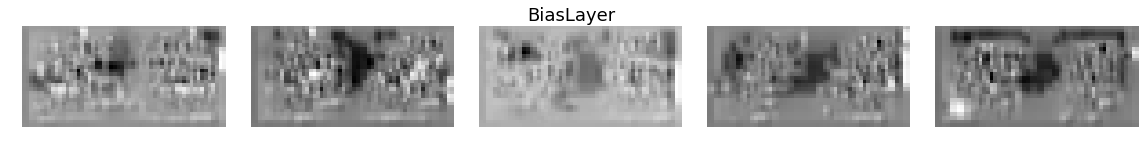

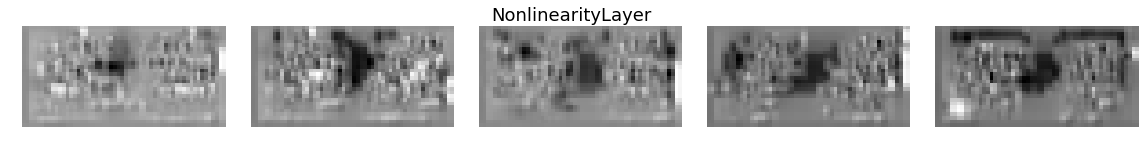

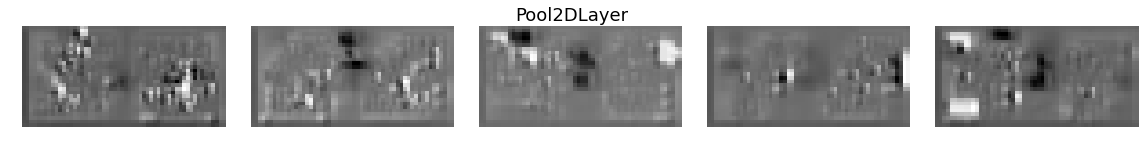

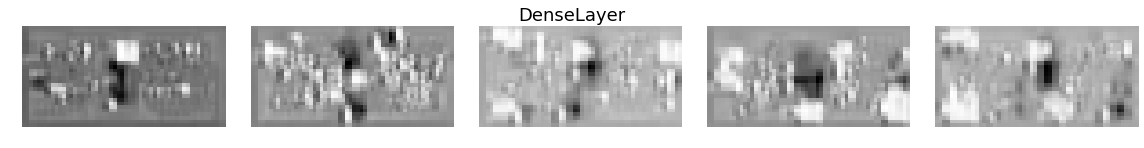

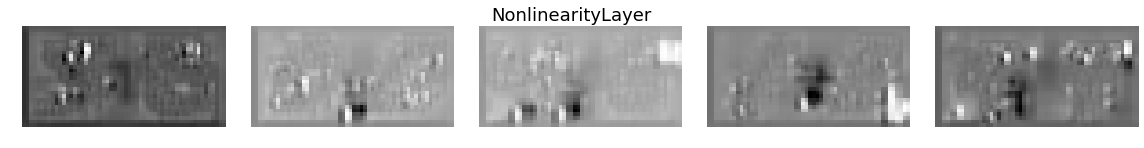

In [33]:
for i_layer, deconved in enumerate(deconved_per_layer):
    fig = plt.figure(figsize=(16,2))
    for i_example in xrange(len(deconved)):
        plt.subplot(1, len(deconved), i_example+1)
        plt.imshow(deconved[i_example].squeeze(), interpolation='nearest', cmap=cm.Greys)
        plt.axis('off')
    # i_layer + 1 since first layer not deconved
    fig.suptitle(all_layers[i_layer+1].__class__.__name__, fontsize=18)
    plt.axis('off')
    plt.tight_layout()

In [1]:
from braindecode.veganlasagne.layers import print_layers
three_layer_model = np.load('data/mnist/two-digit/three-conv-pool-elu.pkl')

all_layers = lasagne.layers.get_all_layers(three_layer_model)
print_layers(three_layer_model)


ImportError: No module named lasagne.layers

In [2]:
from braindecode.veganlasagne.layers import split_out_nonlinearities, split_out_biases
three_layer_model = split_out_nonlinearities(three_layer_model)
three_layer_model = split_out_biases(three_layer_model)
all_layers = lasagne.layers.get_all_layers(three_layer_model)
print_layers(all_layers)

ImportError: No module named lasagne.layers

In [7]:
inputs = T.fmatrix()
outputs = lasagne.layers.get_output(all_layers, inputs=inputs)
all_out_fn = theano.function([inputs], outputs)
all_outs_per_layer = all_out_fn(X_train_flat_both)
acc = (sum(np.argmax(all_outs_per_layer[-1], axis=1) == y_train_both) 
    / float(len(y_train_both)))
print("Accuracy {:.2f}".format(acc * 100))

Accuracy 93.67


In [8]:
from braindecode.analysis.patterns import (compute_topo_covariances, transform_to_patterns,
                                           compute_patterns_for_layers, compute_patterns_for_model,
                                          pattern_deconv)
patterns_per_layer = compute_patterns_for_model(three_layer_model, X_train_flat_both)

INFO:braindecode.analysis.patterns:Compiling forward pass...
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 0: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 1: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 2: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 3: DenseLayer...


In [9]:
[np.max(p) for p in patterns_per_layer]

[0.66738022080843606,
 0.69330405767832359,
 0.23625642808966207,
 2.8794654910680011]

In [11]:
[np.mean(np.abs(p)) for p in patterns_per_layer]

[0.22283646150509048,
 0.22401602378762275,
 0.092965971891208823,
 0.61703502007141919]

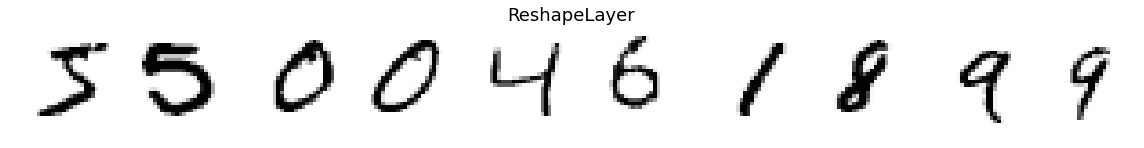

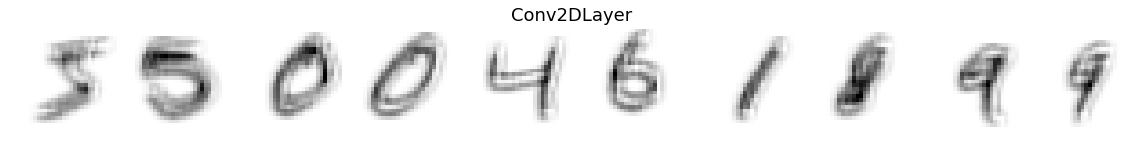

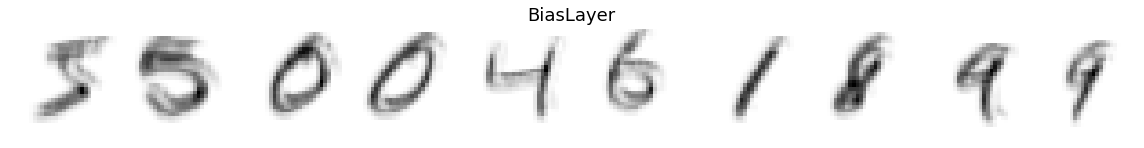

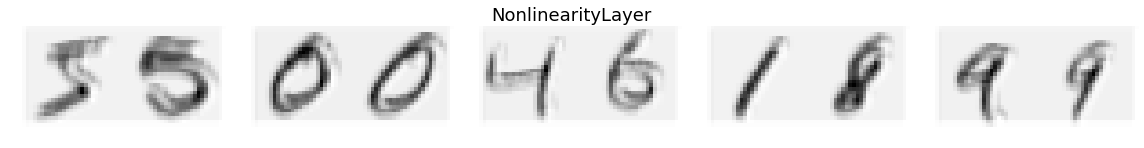

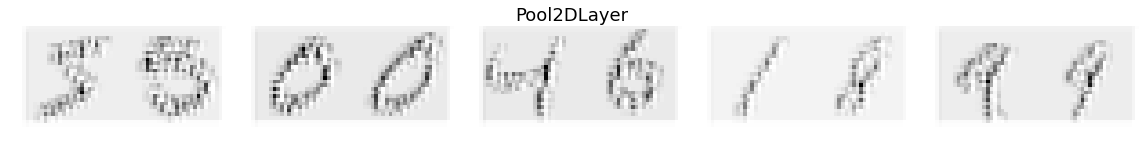

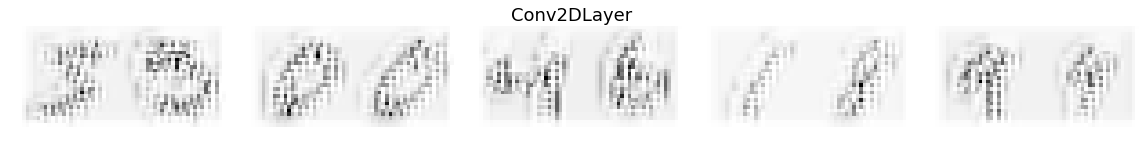

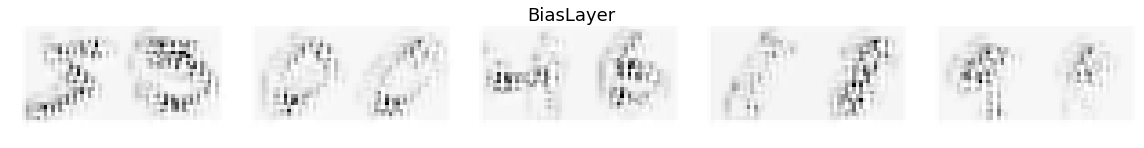

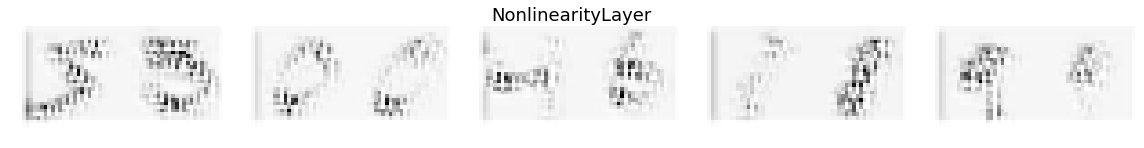

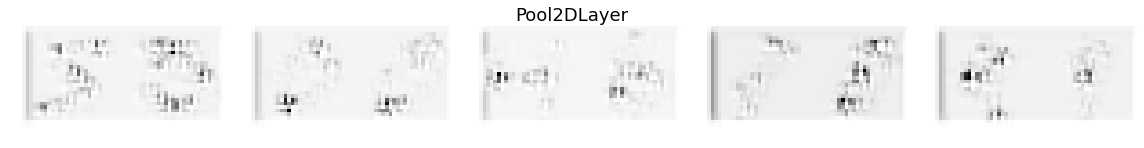

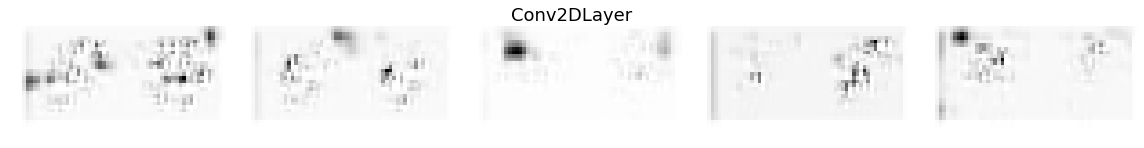

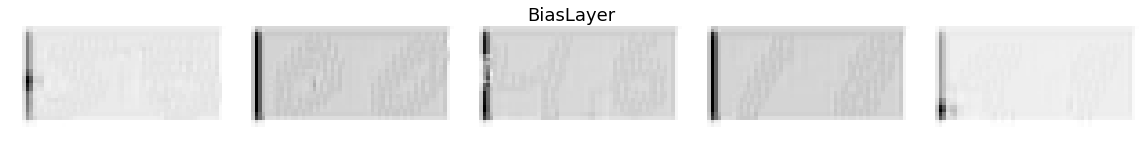

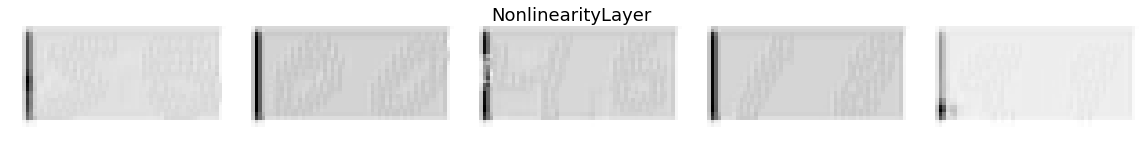

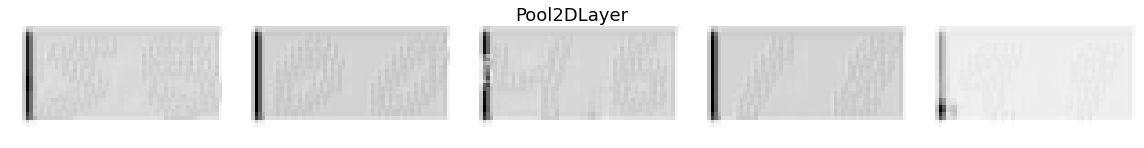

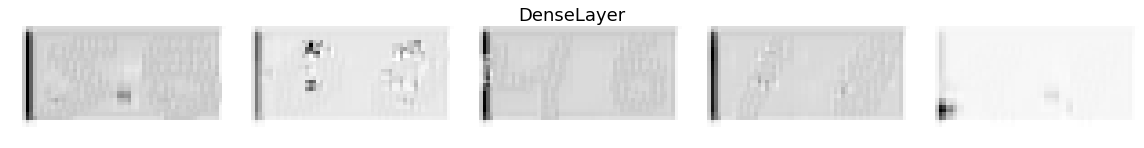

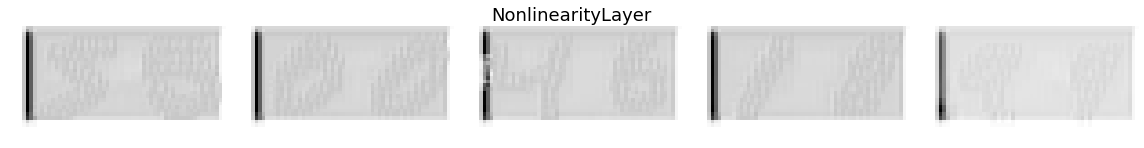

In [12]:
from braindecode.analysis.patterns import pattern_deconv
from matplotlib import cm
trial_inds = range(5)
for i_layer in xrange(1,len(all_layers)):
    inputs = T.fmatrix()
    if len(all_layers[i_layer].output_shape) > 2:
        outputs = T.ftensor4()
    else:
        outputs = T.fmatrix()
    this_layers = all_layers[1:i_layer+1]
    n_patterns = len([l for l in this_layers if hasattr(l, 'W')])
    deconved_var = pattern_deconv(outputs, inputs, this_layers, patterns_per_layer[:n_patterns],
                             enforce_positivity_everywhere=True)
    if i_layer > 1:
        pattern_deconv_fn = theano.function([outputs, inputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds], 
                                     X_train_flat_both[trial_inds])
    else:
        pattern_deconv_fn = theano.function([outputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds])
    fig = plt.figure(figsize=(16,2))
    for i_example in xrange(len(deconved)):
        plt.subplot(1, len(deconved), i_example+1)
        plt.imshow(deconved[i_example].squeeze(), interpolation='nearest', cmap=cm.Greys)
        plt.axis('off')
    fig.suptitle(all_layers[i_layer].__class__.__name__, fontsize=18)
    plt.axis('off')
    plt.tight_layout()